In [750]:
from scipy.optimize import curve_fit 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
%matplotlib inline
plt.rcParams["figure.figsize"] = [15, 10]
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

#LOAD DATA FROM .CSV-file TO DATAFRAME
#SOURCE:  https://ourworldindata.org/coronavirus-source-data
#SOURCE:  https://covid.ourworldindata.org/data/who/full_data.csv
url = 'https://covid.ourworldindata.org/data/ecdc/full_data.csv'
myfile = requests.get(url)
#MAC open('/Users/magnusstorjordsimonsen/Documents/full_data.csv', 'wb').write(myfile.content)
open('C:/Users/magsi110681/Google Drive/Privat/COVID19/full_data.csv', 'wb').write(myfile.content)
#MAC df = pd.read_csv('/Users/magnusstorjordsimonsen/Documents/full_data.csv')
df = pd.read_csv('C:/Users/magsi110681/Documents/COVID19/full_data.csv')
full_data_last_date = df.tail(1).iloc[0]['date']

# Exponential function
def exp_function(x, a, b): 
    return a*np.exp(b*x) 

# Exponential regression. Inputs x and y are SERIES from final_df
def get_exp_fit_array(xValues_series,y_country_data_series):
    # In order for curve_fit to work, we need to delete all nan-values and corresponding x-valuses
    xyValues_df = pd.DataFrame({"xValues": xValues_series})
    xyValues_df['yValues'] = y_country_data_series
    xyValues_df = xyValues_df.dropna()
    # Dataframe -> arrays
    xValues_array = xyValues_df['xValues'].to_numpy() 
    yValues_array = xyValues_df['yValues'].to_numpy()
    # xValues_array start at 1 or 0?
    xValues_array = xValues_array - xValues_array[0]
    # Curve_fit a*exp(b*x)  a=param[0] b=param[1]
    param, param_cov = curve_fit(exp_function,  xValues_array, yValues_array )
    Doubling_Time = np.round(np.log(2)/(param[1]),1)
    return [param[0],param[1], Doubling_Time]

# Get a list with headers from dataframe
def get_name_list_from_dataframe(df):
    name_list = []
    for col in df.columns: 
        name_list.append(col)
    return name_list

# Get list of country names from dataframe
def get_list_of_country_names(df):
    list_of_country_names = []
    list_of_country_names.append(df['location'][0])
    temp_count = 0
    for i in range(0,len(df['location'][:])-1):
        temp_name = df['location'][i]
        if temp_name != list_of_country_names[temp_count]:
            list_of_country_names.append(temp_name)
            temp_count = temp_count + 1
    return list_of_country_names

# Get single country dataframe from original dataframe
def get_df_country(country,df, data_choice, only_data_bigger_than, replace_0_with_NAN):
# data_choice = 2 : new_cases
# data_choice = 3 : new_deaths
# data_choice = 4 : total_cases
# data_choice = 5 : total_deaths
    if data_choice == 2:
        data_choise_string = 'new_cases'
    elif data_choice == 3:
        data_choise_string = 'new_deaths'
    elif data_choice == 4:
        data_choise_string = 'total_cases'
    elif data_choice == 5:
        data_choise_string = 'total_deaths'    
    # Create single country dataframe
    temp_df = df.loc[(df['location'] == country) & (df[data_choise_string] > only_data_bigger_than)]
    # Get the max number of cases per day
    max_number_of_cases = temp_df[data_choise_string][temp_df[data_choise_string].idxmax()]
    # Replace 0 with NaN. Usefull for ploting
    if replace_0_with_NAN == True:
        temp_df = temp_df.replace(0, np.nan)
    # Get start date for data_choice
    start_date = temp_df.iloc[0]['date']
    # Filter out only xValues-column and data_choise_string-column -- REMOVED FROM METHOD: SEE def join_country_dataframes
    # Comment this out if you want all columns for one country
    #temp_df = temp_df.filter(['xValues',data_choise_string], axis=1)
    temp_df = temp_df.filter([data_choise_string], axis=1)
    #Rename column. New name = country name
    temp_df.columns = [country] # Dataframe with one single column + indexes
    # Remove all rows with NAN
    temp_df = temp_df.dropna()
    temp_df.index = range(len(temp_df.index))
    return [start_date, max_number_of_cases, temp_df]

def join_country_dataframes(country_list,df, data_choice, only_data_bigger_than, replace_0_with_NAN):
    list_of_country_dfs = []
    country_with_most_data_values = 'None'
    max_number_of_data_values = 0
    #list_index_for_country_with_most_data_values
    list_index = 0
    # We need to find the dataframe with most data-values and join the other datafraims to it
    for i in range(0,len(country_list)):
        list_of_country_dfs.append(get_df_country(country_list[i],df,data_choice,only_data_bigger_than,replace_0_with_NAN)[2])
        # We need to find the dataframe with most data-values and join the other datafraims to it
        if len(list_of_country_dfs[i])>max_number_of_data_values:
            max_number_of_data_values=len(list_of_country_dfs[i])
            country_with_most_data_values = country_list[i]
            list_index = i
    # Joining all other dataframes to dataframe "country_with_most_data_values"
    final_df = list_of_country_dfs[list_index]
    for i in range(0,len(country_list)):
           if i != list_index:
                final_df = final_df.join(list_of_country_dfs[i])  
    # Change order of countryes in final_df back to same order as country_list
    final_df = final_df[country_list]
    # Add x-values usefull for plotting 
    final_df['xValues'] = pd.DataFrame({"xValues":[x for x in range(0,len(final_df))]})
    #final_df = final_df.join(pd.DataFrame({"xValues":[x for x in range(1,len(final_df)+1)]}))
    return  final_df

def get_numpy_array_from_final_df(final_df):
    numpy_array = final_df.to_numpy() 
    return numpy_array


In [325]:
 get_list_of_country_names(df)

['Afghanistan',
 'Albania',
 'Algeria',
 'Andorra',
 'Angola',
 'Antigua and Barbuda',
 'Argentina',
 'Armenia',
 'Australia',
 'Austria',
 'Azerbaijan',
 'Bahamas',
 'Bahrain',
 'Bangladesh',
 'Barbados',
 'Belarus',
 'Belgium',
 'Belize',
 'Benin',
 'Bermuda',
 'Bhutan',
 'Bolivia',
 'Bosnia and Herzegovina',
 'Brazil',
 'Brunei',
 'Bulgaria',
 'Burkina Faso',
 'Cambodia',
 'Cameroon',
 'Canada',
 'Cape Verde',
 'Cayman Islands',
 'Central African Republic',
 'Chad',
 'Chile',
 'China',
 'Colombia',
 'Congo',
 'Costa Rica',
 "Cote d'Ivoire",
 'Croatia',
 'Cuba',
 'Cyprus',
 'Czech Republic',
 'Democratic Republic of Congo',
 'Denmark',
 'Djibouti',
 'Dominica',
 'Dominican Republic',
 'Ecuador',
 'Egypt',
 'El Salvador',
 'Equatorial Guinea',
 'Eritrea',
 'Estonia',
 'Ethiopia',
 'Faeroe Islands',
 'Fiji',
 'Finland',
 'France',
 'French Polynesia',
 'Gabon',
 'Gambia',
 'Georgia',
 'Germany',
 'Ghana',
 'Gibraltar',
 'Greece',
 'Greenland',
 'Grenada',
 'Guam',
 'Guatemala',
 'Guern

2020-03-25


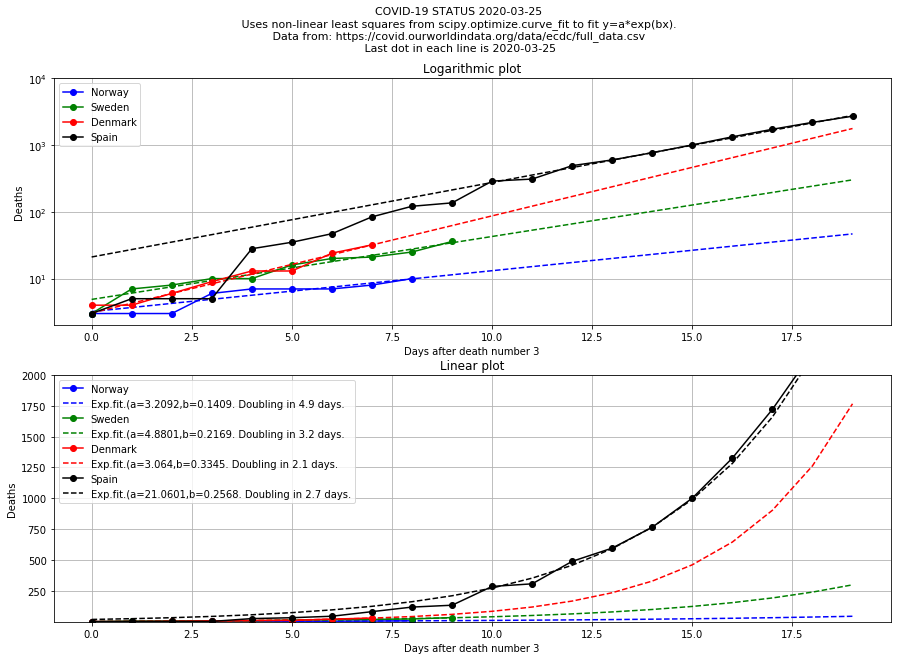

In [818]:
#list_of_country_names = ['Norway','Sweden','Denmark','Spain', 'Italy', 'United States']
#list_of_country_names = ['Spain', 'Italy', 'United States','Iran']
#list_of_country_names = ['United States']
list_of_country_names = ['Norway','Sweden','Denmark', "Spain"]

#join_country_dataframes(country_list,df,data_choice,only_data_bigger_than,replace_0_with_NAN):
# data_choice = 2 : new_cases
# data_choice = 3 : new_deaths
# data_choice = 4 : total_cases
# data_choice = 5 : total_deaths

status_date = df.tail(1).iloc[0]['date']
print(status_date)
final_df  = join_country_dataframes(list_of_country_names,df, 5, 2, True)  
final_array = get_numpy_array_from_final_df(final_df)

# Code example curve fit y=a*exp(b*x)
#[a,b,doubling_time]=get_exp_fit_array(final_df['xValues'],final_df['Sweden'])


color =['blue','green','red','black','cyan','magenta','yellow']    
plt.figure()
plt.suptitle('COVID-19 STATUS ' + full_data_last_date +"\n Uses non-linear least squares from scipy.optimize.curve_fit to fit y=a*exp(bx). \n Data from: https://covid.ourworldindata.org/data/ecdc/full_data.csv \n Last dot in each line is "+full_data_last_date, fontsize=11)
#temp_string = str("Exp.fit.(a="+str(round(a,4))+",b="+str(round(b,4))+") " + list_of_country_names[i])+ ". Doubling time in days: "+str(Doubling_Time) 
plt.subplot(211)
plt.title("Logarithmic plot")
plt.yscale('symlog')
plt.grid(True, which="both")
plt.ylim(2, 10000)
plt.xlabel('Days after death number 3')
plt.ylabel('Deaths')
for i in range(0,len(list_of_country_names)):
    plt.plot(final_array[:,len(list_of_country_names)], final_array[:,i],'o-', color=color[i], label = list_of_country_names[i])
    [a,b,doubling_time] = get_exp_fit_array(final_df['xValues'],final_df[list_of_country_names[i]])
    #temp_string = str("Exp.fit.(a="+str(round(a,4))+",b="+str(round(b,4))+". Doubling in "+str(doubling_time)+" days.") 
    plt.plot(final_array[:,len(list_of_country_names)], a*np.exp((final_array[:,len(list_of_country_names)])*b),'--',color=color[i]) 
plt.legend()
plt.subplot(212)
plt.title("Linear plot")
plt.grid(True,which="both")
plt.ylim(2, 2000)
plt.xlabel('Days after death number 3')
plt.ylabel('Deaths')
for i in range(0,len(list_of_country_names)):
    plt.plot(final_array[:,len(list_of_country_names)], final_array[:,i],'o-',color=color[i], label = list_of_country_names[i])
    [a,b,doubling_time] = get_exp_fit_array(final_df['xValues'],final_df[list_of_country_names[i]])
    temp_string = str("Exp.fit.(a="+str(round(a,4))+",b="+str(round(b,4))+". Doubling in "+str(doubling_time)+" days.") 
    plt.plot(final_array[:,len(list_of_country_names)], a*np.exp((final_array[:,len(list_of_country_names)])*b),'--',color=color[i], label=temp_string)
plt.legend()
plt.show()


In [504]:
df = pd.DataFrame({'key': ['K0', 'K1', 'K2', 'K3', 'K4', 'K5']})
other = pd.DataFrame({ 'B': ['B0', 'B1', 'B2']})
print(df)
print(other)

  key
0  K0
1  K1
2  K2
3  K3
4  K4
5  K5
    B
0  B0
1  B1
2  B2


In [505]:
df=df.join(other)
print(df)

  key    B
0  K0   B0
1  K1   B1
2  K2   B2
3  K3  NaN
4  K4  NaN
5  K5  NaN


In [507]:
df=df[['B','key']]
print(df)

     B key
0   B0  K0
1   B1  K1
2   B2  K2
3  NaN  K3
4  NaN  K4
5  NaN  K5


In [573]:
# Import pandas package  
import pandas as pd 
  
# Define a dictionary containing Students data 
data = {'Name': ['Jai', 'Princi', 'Gaurav', 'Anuj'], 
        'Height': [5.1, 6.2, 5.1, 5.2], 
        'Qualification': ['Msc', 'MA', 'Msc', 'Msc']} 
  
# Convert the dictionary into DataFrame 
df = pd.DataFrame(data) 
print(df['Name'])

# Declare a list that is to be converted into a column 
df2 = pd.DataFrame({'Address': ['Delhi', 'Bangalore', 'Chennai', 'Patna']}) 
df['Address'] = df2['Address']

# Using 'Address' as the column name 
# and equating it to the list 

# Observe the result 
print(df) 

0       Jai
1    Princi
2    Gaurav
3      Anuj
Name: Name, dtype: object
     Name  Height Qualification    Address
0     Jai     5.1           Msc      Delhi
1  Princi     6.2            MA  Bangalore
2  Gaurav     5.1           Msc    Chennai
3    Anuj     5.2           Msc      Patna
